In [17]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [19]:
import mglearn

In [2]:
aclImdb_path = os.path.join("D:\\", "program", "programming", "study", "data", "aclImdb_v1")
reviews_train = load_files(os.path.join(aclImdb_path, "train"))
reviews_test = load_files(os.path.join(aclImdb_path, "test"))

## trainデータの作成

In [4]:
df_train = pd.DataFrame({"data": reviews_train["data"],
                         "target": reviews_train["target"]})

df_train = df_train.drop(df_train[df_train["target"] == 2].index, axis=0)
df_train["data"] = df_train["data"].str.decode('utf-8').str.replace("b['\"]|'|<br />", "", regex=True)

In [5]:
df_train

,data,target
3,Dan Katzir has produced a wonderful film that ...,1
4,If you want Scream or anything like the big-st...,1
9,Outlandish premise that rates low on plausibil...,0
11,Lets face it-- if you rented a STDVD sequel of...,0
12,Bizarre Tobe Hooper exercise regarding an unfo...,0
...,...,...
74981,Well then. I just watched an crap-load of movi...,0
74986,I just read a review defending this film becau...,0
74987,Jackie Chans classic directorial feature POLIC...,1
74989,Walt Disney & his 9 Old Men put their own 1950...,1


## testデータの作成

In [6]:
df_test = pd.DataFrame({"data": reviews_test["data"],
                        "target": reviews_test["target"]})
df_test = df_test.drop(df_test[df_test["target"] == 2].index, axis=0)
df_test["data"] = df_test["data"].str.decode('utf-8').str.replace("b['\"]|'|<br />", "", regex=True)

### bards_wordsについて

In [7]:
bards_words = ["The fool doth think he is wise,",
               "but the wise man knows himself to be a fool"]
print("bards_words:\n", bards_words)

bards_words:
 ['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']


In [8]:
countv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print("Vocabulary size:", len(countv.vocabulary_))
print("Vocabulary:\n", countv.get_feature_names_out())

Vocabulary size: 13
Vocabulary:
 ['be' 'but' 'doth' 'fool' 'he' 'himself' 'is' 'knows' 'man' 'the' 'think'
 'to' 'wise']


In [9]:
countv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print("Vocabulary size:", len(countv.vocabulary_))
print("Vocabulary:\n", countv.get_feature_names_out())

Vocabulary size: 14
Vocabulary:
 ['be fool' 'but the' 'doth think' 'fool doth' 'he is' 'himself to'
 'is wise' 'knows himself' 'man knows' 'the fool' 'the wise' 'think he'
 'to be' 'wise man']


In [10]:
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print("Vocabulary size:", len(cv.vocabulary_))
print("Vocabulary:\n", cv.get_feature_names_out())

Vocabulary size: 39
Vocabulary:
 ['be' 'be fool' 'but' 'but the' 'but the wise' 'doth' 'doth think'
 'doth think he' 'fool' 'fool doth' 'fool doth think' 'he' 'he is'
 'he is wise' 'himself' 'himself to' 'himself to be' 'is' 'is wise'
 'knows' 'knows himself' 'knows himself to' 'man' 'man knows'
 'man knows himself' 'the' 'the fool' 'the fool doth' 'the wise'
 'the wise man' 'think' 'think he' 'think he is' 'to' 'to be' 'to be fool'
 'wise' 'wise man' 'wise man knows']


## IMDb映画レビュー

In [16]:
pipe = make_pipeline(
    TfidfVectorizer(min_df=5),
    LogisticRegression()
)

param_grid = {
    "logisticregression__C": 10.0 ** np.arange(-3, 2),
    "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]
}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(df_train["data"], df_train["target"])


print("Best cross-validation score:", grid.best_score_)
print("Best parameters:\n", grid.best_params_)

Best cross-validation score: 0.9051199999999999
Best parameters:
 {'logisticregression__C': 10.0, 'tfidfvectorizer__ngram_range': (1, 3)}


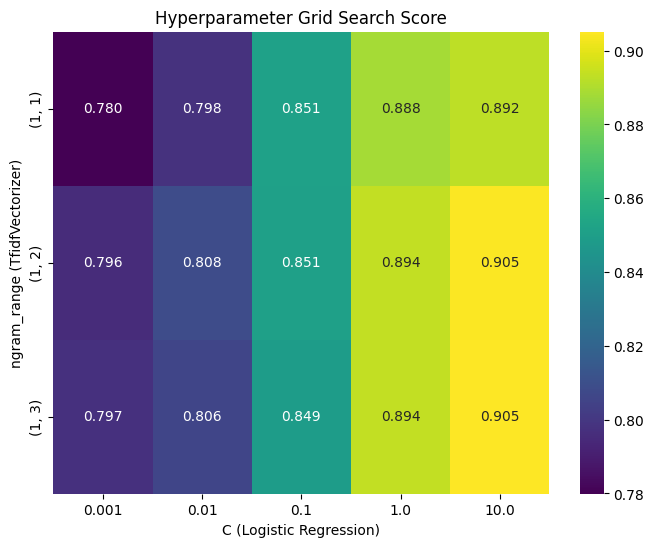

In [18]:
scores = grid.cv_results_["mean_test_score"].reshape(-1, 3).T

# heatmapとしてスコアを取り出す

plt.figure(figsize=(8, 6))
sns.heatmap(scores, annot=True, fmt=".3f", cmap="viridis", xticklabels=param_grid["logisticregression__C"], yticklabels=param_grid["tfidfvectorizer__ngram_range"])
plt.xlabel("C (Logistic Regression)")
plt.ylabel("ngram_range (TfidfVectorizer)")

plt.title("Hyperparameter Grid Search Score")
plt.show()

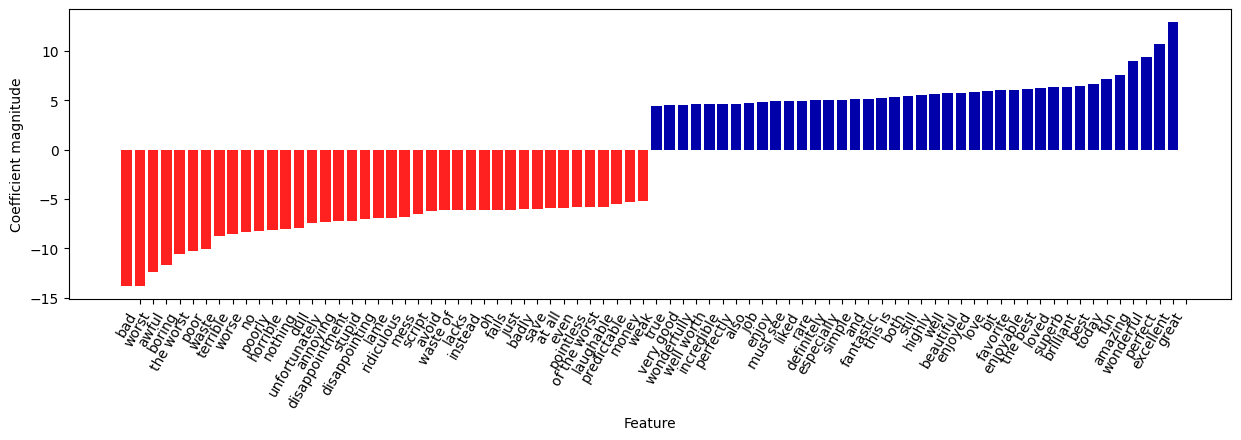

In [21]:
vect = grid.best_estimator_.named_steps["tfidfvectorizer"]
feature_names = np.array(vect.get_feature_names_out())
coef = grid.best_estimator_.named_steps["logisticregression"].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)

In [22]:
grid.score(df_test["data"], df_test["target"])

0.90308

In [25]:
import spacy
import nltk

In [31]:
# spacyの英語モデルをロード
en_nlp = spacy.load("en_core_web_sm")

# nltkのPorter stemmerのインスタンスを作成
stemmer = nltk.stem.PorterStemmer()


# spacyによる見出し語化とnltkにおよる語幹処理を比較する関数
def compare_normalization(doc):
    # spacyで文章をトークン分割
    doc_spacy = en_nlp(doc)
    # spacyで見つけた見出し語を表示
    print("Lemmatization:", [token.lemma_ for token in doc_spacy])
    # Porter stemmerで見つけたトークンを表示
    print("Stemming:", [stemmer.stem(token.norm_.lower()) for token in doc_spacy])

In [33]:
compare_normalization("Our meeting today was worse than yesterday,"
                      "I'm scared of meeting the clients tomorrow")

Lemmatization: ['our', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', "I'm", 'scare', 'of', 'meet', 'the', 'client', 'tomorrow']
Stemming: ['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', "i'm", 'scare', 'of', 'meet', 'the', 'client', 'tomorrow']


In [39]:
import re
from spacy.tokens import Doc

en_nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])
regexp = re.compile('(?u)\\b\\w\\w+\\b')

# --- ここから修正 ---

# 1. 新しいtokenizerを定義
def custom_regexp_tokenizer(text):
    # 正規表現で単語リストを作成
    tokens = regexp.findall(text)
    # 単語リストから直接Docオブジェクトを作成
    return Doc(en_nlp.vocab, words=tokens)

# 2. en_nlpのtokenizerを置き換え
en_nlp.tokenizer = custom_regexp_tokenizer

# 3. レンマ化を行う関数 (この部分は変更なし)
def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

# --- 修正ここまで ---


# CountVectorizerをカスタムトークン分割器を使って定義する
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)



In [40]:
# これで正常に動作します
X_train_lemma = lemma_vect.fit_transform(df_train["data"])
print("X_train_lemma.shape: ", X_train_lemma.shape)

vect = CountVectorizer(min_df=5).fit(df_train["data"])
X_train = vect.transform(df_train["data"])
print("X_train.shape")

c:\Users\CHU1P\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


X_train_lemma.shape:  (25000, 21835)
X_train.shape
